In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# Import Everything
import cv2
import matplotlib.pyplot as plt
import utils
import numpy as np
# Set image path
folder = f"./equations"

In [3]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [41]:
def boundingBoxes(fileName):
    # Read Input image
    inputImage = cv2.imread(fileName)
    h,w,_ = inputImage.shape
    # inputImage = cv2.resize(inputImage, (w//5, h//5), cv2.INTER_AREA, fx=0.1, fy=0.1)
    # Deep copy for results
    inputImageCopy = inputImage.copy()
    # Convert BGR to grayscale
    grayscaleImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    # Threshold via Otsu
    threshValue, binaryImage = cv2.threshold(grayscaleImage, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # Get each bounding box
    # Find the big contours/blobs on the filtered image
    contours, hierarchy = cv2.findContours(binaryImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours,_ = sort_contours(contours)
    # contours, _ = sort_contours(contours, "top-to-bottom")


    # Expand the bounding box size
    expansion_value = 20  # Increase this value to expand the bounding boxes more
    bounding_boxes = []
    # Look for the outer bounding boxes (no children)
    for _, c in enumerate(contours):
        # Get the bounding rectangle of the current contour
        boundRect = cv2.boundingRect(c)
        
        # Expand bounding box
        rectX = max(0, boundRect[0] - expansion_value)
        rectY = max(0, boundRect[1] - expansion_value)
        rectWidth = min(inputImage.shape[1] - rectX, boundRect[2] + 2 * expansion_value)
        rectHeight = min(inputImage.shape[0] - rectY, boundRect[3] + 2 * expansion_value)
        
        # Draw expanded bounding box
        color = (0, 255, 0)
        start_X = int(rectX)
        end_X = int(start_X + rectWidth)
        start_Y = int(rectY)
        end_Y = int(start_Y + rectHeight)
        contoursImage = inputImageCopy.copy()
        bounding_boxes.append(contoursImage[start_Y:end_Y, start_X:end_X])
        cv2.rectangle(inputImageCopy, (start_X, start_Y),
                    (end_X, end_Y), color, 2)

    # Show the image with expanded bounding boxes
    bb_image = cv2.cvtColor(inputImageCopy, cv2.COLOR_BGR2RGB)
    plt.imshow(bb_image)
    return bounding_boxes

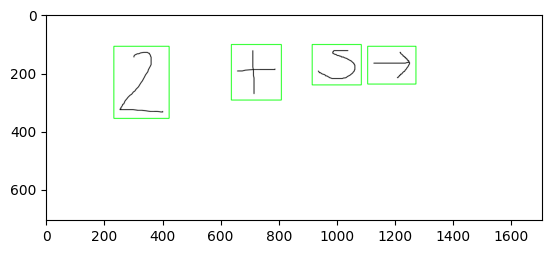

In [92]:
fileName = f"{folder}/s.png"
bounding_boxes = boundingBoxes(fileName)

In [82]:
import utils

In [83]:
len(bounding_boxes)

4

In [84]:
from model import Sequential

In [85]:
labels = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '-': 11, 'div': 12, 'rightarrow': 13, 'times': 14, 'u': 15, 'v': 16, 'w': 17, 'y': 18, 'z': 19}

In [47]:
def idtolabel(labels_map, y):
    for key, value in labels_map.items():
        if y == value:
            return key
        
    return -1

In [48]:
np.random.seed(42)
sequential_model = utils.load_model(model_path="./models/deep_1_20231207123539.pkl")

In [49]:
bounding_boxes[0].shape

(383, 232, 3)

In [69]:
import cv2

def preprocess_img_path(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=0)
    img = cv2.dilate(img, np.ones((2,2), np.uint8), iterations=1)
    return img

In [79]:
test_img = preprocess_img_path("../data/2/2_61.jpg")

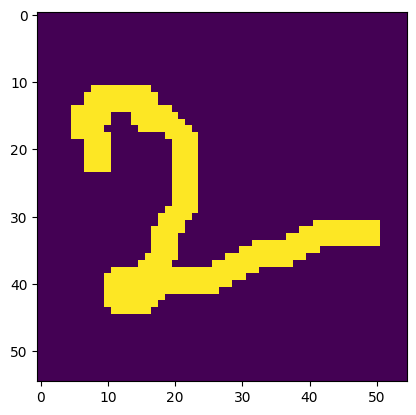

In [80]:
plt.imshow(test_img)

In [73]:
test_img.shape

(55, 55)

In [76]:
np.argmax(sequential_model._forward(utils.minmax_normalize(np.expand_dims(test_img, axis=(0,1)))), axis=1)

array([2], dtype=int64)

In [87]:
def preprocess_image(img):
    img = cv2.resize(img, (45,45), cv2.INTER_AREA, fx=0.1, fy=0.1)   
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=0)
    img = cv2.dilate(img, np.ones((2,2), np.uint8), iterations=1)
    return img

In [88]:
def predict(model:Sequential, img):
    # print(img.shape, img.max())
    logits = model._forward(img)
    y_pred = np.argmax(logits, axis=1)
    return y_pred
    

In [25]:
labels = {'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'div': 10,
 'rightarrow': 11,
 'times': 12,
 'u': 13,
 'v': 14,
 'w': 15,
 'y': 16,
 'z': 17,
 '+': 18,
 '-': 19}

In [61]:

def get_symbols(model, bounding_boxes):
    equation_string = []
    for bb in bounding_boxes:
        preprocessed_img = utils.preprocess_image(bb)
        preprocessed_img = utils.minmax_normalize(preprocessed_img)
        preprocessed_img = np.expand_dims(preprocessed_img, (0,1))
        max_index = predict(model, preprocessed_img)
        predicted_class = idtolabel(labels, max_index)
        equation_string.append(predicted_class)

    return equation_string



In [62]:
labels

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '+': 10,
 '-': 11,
 'div': 12,
 'rightarrow': 13,
 'times': 14,
 'u': 15,
 'v': 16,
 'w': 17,
 'y': 18,
 'z': 19}

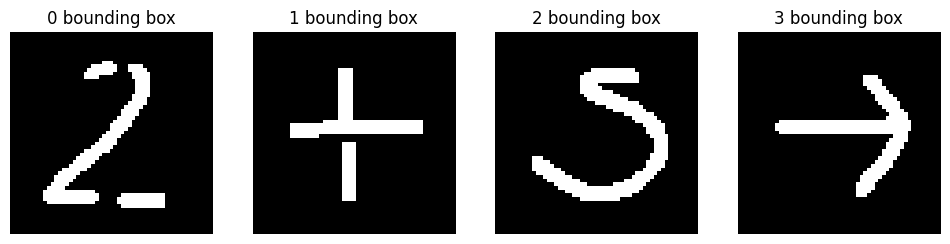

In [94]:
utils.displayBoundingBoxes(bounding_boxes, rows=1, cols=4)

In [93]:
symbols_list = get_symbols(sequential_model, bounding_boxes)
print(symbols_list)

['2', 'y', '1', 'y']


In [829]:
import mnist
x_mnist_train, y_mnist_train, x_mnist_test, y_mnist_test = mnist.load()

x_mnist_train, x_mnist_test = x_mnist_train.reshape((x_mnist_train.shape[0],28, 28)), x_mnist_test.reshape((x_mnist_test.shape[0], 28, 28))

array([19], dtype=int64)

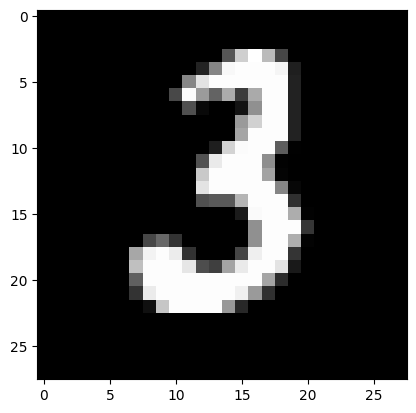

In [830]:
idx = np.random.randint(len(x_mnist_train))
plt.imshow(x_mnist_train[idx], cmap="gray")
predict(sequential_model, utils.minmax_normalize(preprocess_image(x_mnist_train[idx])))

(1, 1, 55, 55)
[4]


array([4], dtype=int64)

In [269]:
preprocess_image(x_mnist_train[0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [301]:
def readandpreprocess(img):
    kernel = np.array([[0, -1, 0], [-1, 6, -1], [0, -1, 0]])
    img = cv2.resize(img, (55, 55), cv2.INTER_CUBIC, fx=0.1, fy=0.1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    img = cv2.dilate(img, np.ones((2, 2), np.uint8), iterations=1)
    img = cv2.filter2D(img, -1, kernel)
    return img

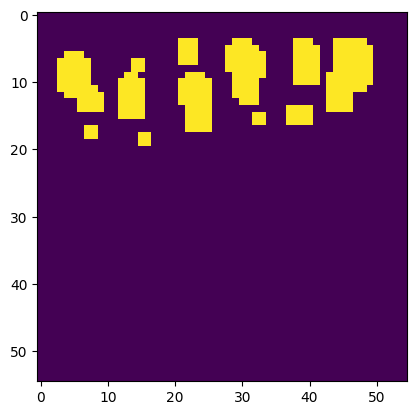

In [338]:
img = readandpreprocess("./equations/nums.png")
plt.imshow(img)

5

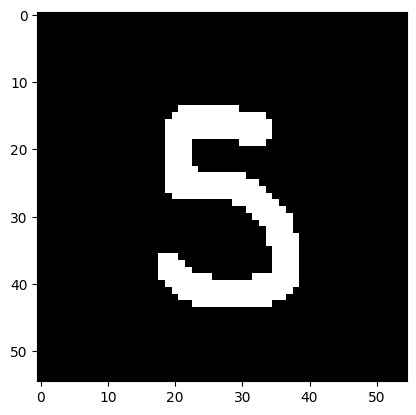

In [305]:
test_image = np.expand_dims(img, (0,1))
test_image = utils.minmax_normalize(test_image)

plt.imshow(test_image.reshape(55, 55), cmap="gray")

np.argmax(sequential_model._forward(test_image))